<div style="border:solid purple 2px; padding: 20px">

<h1 style="color:purple; margin-bottom:20px">Задача</h1>

Проанализировать поведение клиентов и сделать вывод — какой тариф окажется более востребованым.

</div>

<div style="border:solid purple 2px; padding: 20px">

<h3 style="color:purple; margin-bottom:20px">Предобработка данных</h3>

</div>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

pd.set_option('float_format', '{:.2f}'.format)

In [2]:
data_calls = pd.read_csv('/Project_3/calls.csv')
data_internet = pd.read_csv('/Project_3/internet.csv')
data_messege = pd.read_csv('/Project_3/messages.csv')
data_tariffs = pd.read_csv('/Project_3/tariffs.csv')
data_user = pd.read_csv('/Project_3/users.csv')

list_of_data = [data_calls, data_internet, data_messege, data_tariffs, data_user]


In [3]:
# Вывод информации о таблице
def data_info(tables):
    for table in tables:
        print('Таблица')
        print(table.info())
        print()
        
    return

In [4]:
# Вывод describe
def data_describe(tables):
    for table in tables:
        print('Таблица')
        table = table.drop_duplicates().reset_index(drop=True)
        print(table.describe())
        print()
    return

In [5]:
# Преобразование в datetime
data_calls['call_date'] = pd.to_datetime(data_calls['call_date'], format='%Y-%m-%d')
data_internet['session_date'] = pd.to_datetime(data_internet['session_date'], format='%Y-%m-%d')
data_messege['message_date'] = pd.to_datetime(data_messege['message_date'], format='%Y-%m-%d')
data_user['reg_date'] = pd.to_datetime(data_user['reg_date'], format='%Y-%m-%d')

In [6]:
data_info(list_of_data)

Таблица
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null datetime64[ns]
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 6.2+ MB
None

Таблица
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null datetime64[ns]
user_id         149396 non-null int64
dtypes: datetime64[ns](1), float64(1), int64(1), object(1)
memory usage: 4.6+ MB
None

Таблица
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null datetime64[ns]
user_id         123036 non-null int64
dtypes: datetime64[ns](1), int64

In [7]:
data_describe(list_of_data)

Таблица
       duration   user_id
count 202607.00 202607.00
mean       6.76   1253.94
std        5.84    144.72
min        0.00   1000.00
25%        1.30   1126.00
50%        6.00   1260.00
75%       10.70   1379.00
max       38.00   1499.00

Таблица
        mb_used   user_id
count 149396.00 149396.00
mean     370.19   1252.10
std      278.30    144.05
min        0.00   1000.00
25%      138.19   1130.00
50%      348.01   1251.00
75%      559.55   1380.00
max     1724.83   1499.00

Таблица
        user_id
count 123036.00
mean    1256.99
std      143.52
min     1000.00
25%     1134.00
50%     1271.00
75%     1381.00
max     1499.00

Таблица
       messages_included  mg_per_month_included  minutes_included  \
count               2.00                   2.00              2.00   
mean              525.00               23040.00           1750.00   
std               671.75               10861.16           1767.77   
min                50.00               15360.00            500.00   
25%     


<div style="border:solid purple 2px; padding: 20px">
<h3> Звонки </h3>
</div>

<div style="border:solid purple 2px; padding: 20px">
Много нулевых звонков, считаю это недозвонами, полагаю это звонки, которые заканчиваются репликой автоинформатора ("абонент не доступен", "абонент разговаривает", ...)
    
Обнаружила, что нулевые звонки часто совпадают по дате с ненулевыми звонками. 
Вероятен недозвон, который засчитывается за оплаченную минуту.
Заменю 0.0 на 0.1

</div>

In [8]:
data_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [9]:
data_user.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [10]:
data_calls.head(75).sort_values(by='call_date')
data_calls['duration'] = np.where(data_calls['duration']<0.1, 0.1, data_calls['duration'])

<div style="border:solid purple 2px; padding: 20px">
<h3>
    Найдем количество сделанных звонков и израсходованных минут разговора по месяцам для каждого пользователя
</h3>

</div>

In [11]:
#Округлим значения до больших целых, исходя из условий оплаты
data_calls['duration'] = data_calls['duration'].apply(np.ceil)
data_internet['mb_used'] = data_internet['mb_used'].apply(np.ceil)

In [12]:
data_calls['month'] = pd.DatetimeIndex(data_calls['call_date']).month

In [13]:
data_calls_group = data_calls.groupby(['user_id', 'month']).agg({'duration': ['sum', 'count']})
data_calls_group.set_axis(['calls_duration', 'duration_count'], axis='columns', inplace=True)
data_calls_group.head()

calls_duration  duration_count
user_id month                                
1000    5              164.00              22
        6              187.00              43
        7              346.00              47
        8              418.00              52
        9              478.00              58

<div style="border:solid purple 2px; padding: 20px">
<h3> 
    Интернет 
    </h3>
    
</div>


<div style="border:solid purple 2px; padding: 20px">
Принимаю нули за округление. Возможно user подключился к сети (скачал несколько Кбайт) и сразу вышел.
Меняю на 0.1
Если есть запись в таблице, значит деньги сняли. </div>

In [14]:
data_internet[data_internet['mb_used']<0.1] # 19608 нулей
data_internet['mb_used'] = np.where(data_internet['mb_used']<0.1, 0.1, data_internet['mb_used'])

<div style="border:solid purple 2px; padding: 20px">
<h3>
    Найдем объем израсходованного интернет-трафика по месяцам для каждого пользователя
</h3>

</div>

In [15]:
data_internet.head()

,id,mb_used,session_date,user_id
0,1000_0,113.00,2018-11-25,1000
1,1000_1,1053.00,2018-09-07,1000
2,1000_2,1198.00,2018-06-25,1000
3,1000_3,551.00,2018-08-22,1000
4,1000_4,303.00,2018-09-24,1000


In [16]:
data_internet['month'] = pd.DatetimeIndex(data_internet['session_date']).month

In [17]:
data_internet_group = data_internet.groupby(['user_id', 'month']).agg({'mb_used': ['sum']})
data_internet_group.set_axis(['mb_sum'], axis='columns', inplace=True)
data_internet_group.head()

mb_sum
user_id month         
1000    5      2256.10
        6     23257.50
        7     14016.10
        8     14070.20
        9     14581.20


<div style="border:solid purple 2px; padding: 20px">
<h3> Сообщения </h3>
</div>

<div style="border:solid purple 2px; padding: 20px">
<h3>
    Найдем количество отправленных сообщений по месяцам для каждого пользователя
</h3>

</div>

In [18]:
data_messege['month'] = pd.DatetimeIndex(data_messege['message_date']).month
data_messege_group = data_messege.groupby(['user_id', 'month']).agg({'id': ['count']})
data_messege_group.set_axis(['sum_messege'], axis='columns', inplace=True)

In [19]:
df_all = data_calls_group \
    .merge(data_messege_group, on=['user_id', 'month'], how='outer') \
    .merge(data_internet_group, on=['user_id', 'month'], how='outer') \
    .reset_index() \
    .merge(data_user, how='left', left_on='user_id', right_on='user_id')
df_all.head()

,user_id,month,calls_duration,duration_count,sum_messege,mb_sum,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,5,164.00,22.00,22.00,2256.10,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1000,6,187.00,43.00,60.00,23257.50,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
2,1000,7,346.00,47.00,75.00,14016.10,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
3,1000,8,418.00,52.00,81.00,14070.20,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
4,1000,9,478.00,58.00,57.00,14581.20,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra


<div style="border:solid purple 2px; padding: 20px">
<h3>
    Найдем помесячную выручку с каждого пользователя.
</h3>

</div>



In [20]:
# Количество пользователей - 498, 2 не пользуются связью
df_all.groupby(by='user_id',as_index = False).agg({'month': ['count']}).head()

,user_id,month
,,count
0,1000,8
1,1001,2
2,1002,7
3,1003,5
4,1004,8


In [21]:
# По col группируем
def count_to_group(table, col, data_user=data_user):
    
    table_group = table.groupby([col], as_index = False).agg({'calls_duration': ['sum','count'],
                        'mb_sum':['sum','count'], 'sum_messege':['sum','count'], 'paid':['sum']})
    
    table_group.set_axis([table[col].name, 'calls_duration','calls_count', 'mb_sum','mb_count', 
                          'sum_messege','messege_count', 'paid'], axis='columns', inplace=True)
    
    if 'user_id' == col:
        table_group = table_group.join(data_user[['user_id', 'tariff']].set_index('user_id'),
                                       on='user_id')
    
    table_group['calls_duration'] = table_group['calls_duration'] / table_group['calls_count']
    table_group['mb_sum'] = table_group['mb_sum'] / table_group['mb_count']
    table_group['sum_messege'] = table_group['sum_messege'] / table_group['messege_count']
    table_group = table_group.fillna(0)
    
    table_group['sum_messege'] = table_group['sum_messege'].astype('int')
    
    table_group = table_group.drop(['calls_count', 'mb_count', 'messege_count'], axis=1)
   
    return(table_group)

In [22]:
data_tariffs.set_axis(['messages_included', 'mg_per_month_included', 'minutes_included',
    'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute','tariff'], axis= 'columns', inplace=True)

In [23]:
data_tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [24]:
df_all = df_all.merge(data_tariffs, on='tariff', how='left')
df_all.head()

,user_id,month,calls_duration,duration_count,sum_messege,mb_sum,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,164.00,22.00,22.00,2256.10,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,187.00,43.00,60.00,23257.50,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,346.00,47.00,75.00,14016.10,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,418.00,52.00,81.00,14070.20,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,478.00,58.00,57.00,14581.20,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [25]:
df_all['paid_min'] = df_all['calls_duration']-df_all['minutes_included']
df_all['paid_mb'] = (df_all['mb_sum']-df_all['mg_per_month_included'])/1024
df_all['paid_messege'] = df_all['sum_messege']-df_all['messages_included']


In [26]:
for col in ['paid_min', 'paid_mb', 'paid_messege']:
    df_all[col].replace(df_all.loc[df_all[col] <0, col], 0,inplace = True)
    df_all[col] = df_all[col].fillna(0)

In [27]:
df_all.columns

Index(['user_id', 'month', 'calls_duration', 'duration_count', 'sum_messege',
       'mb_sum', 'age', 'churn_date', 'city', 'first_name', 'last_name',
       'reg_date', 'tariff', 'messages_included', 'mg_per_month_included',
       'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message',
       'rub_per_minute', 'paid_min', 'paid_mb', 'paid_messege'],
      dtype='object')

In [28]:
df_all.loc[:,['user_id', 'month', 'calls_duration', 'duration_count', 'sum_messege',
       'mb_sum', 'tariff', 'messages_included', 'mg_per_month_included',
       'minutes_included', 'rub_monthly_fee', 'rub_per_gb', 'rub_per_message',
       'rub_per_minute', 'paid_min', 'paid_mb', 'paid_messege']].head(10)

,user_id,month,calls_duration,duration_count,sum_messege,mb_sum,tariff,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,paid_min,paid_mb,paid_messege
0,1000,5,164.00,22.00,22.00,2256.10,ultra,1000,30720,3000,1950,150,1,1,0.00,0.00,0.00
1,1000,6,187.00,43.00,60.00,23257.50,ultra,1000,30720,3000,1950,150,1,1,0.00,0.00,0.00
2,1000,7,346.00,47.00,75.00,14016.10,ultra,1000,30720,3000,1950,150,1,1,0.00,0.00,0.00
3,1000,8,418.00,52.00,81.00,14070.20,ultra,1000,30720,3000,1950,150,1,1,0.00,0.00,0.00
4,1000,9,478.00,58.00,57.00,14581.20,ultra,1000,30720,3000,1950,150,1,1,0.00,0.00,0.00
5,1000,10,363.00,57.00,73.00,14717.00,ultra,1000,30720,3000,1950,150,1,1,0.00,0.00,0.00
6,1000,11,344.00,43.00,58.00,14768.10,ultra,1000,30720,3000,1950,150,1,1,0.00,0.00,0.00
7,1000,12,341.00,46.00,70.00,9827.20,ultra,1000,30720,3000,1950,150,1,1,0.00,0.00,0.00
8,1001,11,444.00,59.00,nan,18452.80,smart,50,15360,500,550,200,3,3,0.00,3.02,0.00
9,1001,12,430.00,63.00,nan,14053.60,smart,50,15360,500,550,200,3,3,0.00,0.00,0.00


In [29]:
df_all['paid_min'] = df_all['paid_min']*df_all['rub_per_minute']
df_all['paid_mb'] = df_all['paid_mb']*df_all['rub_per_gb']
df_all['paid_messege'] = df_all['paid_messege']*df_all['rub_per_message']

df_all['paid'] = df_all['paid_min'] + df_all['paid_mb'] + df_all['paid_messege'] + df_all['rub_monthly_fee']

In [30]:
df_all.loc[:,['user_id', 'month', 'calls_duration', 'duration_count', 'sum_messege',
       'mb_sum', 'rub_per_gb', 'paid_min', 'paid_mb', 'paid_messege', 'paid']].head()

,user_id,month,calls_duration,duration_count,sum_messege,mb_sum,rub_per_gb,paid_min,paid_mb,paid_messege,paid
0,1000,5,164.00,22.00,22.00,2256.10,150,0.00,0.00,0.00,1950.00
1,1000,6,187.00,43.00,60.00,23257.50,150,0.00,0.00,0.00,1950.00
2,1000,7,346.00,47.00,75.00,14016.10,150,0.00,0.00,0.00,1950.00
3,1000,8,418.00,52.00,81.00,14070.20,150,0.00,0.00,0.00,1950.00
4,1000,9,478.00,58.00,57.00,14581.20,150,0.00,0.00,0.00,1950.00


<div style="border:solid purple 2px; padding: 20px">
<h3> Тарифы </h3>
</div>

In [31]:
data_tariffs

,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra



<div style="border:solid purple 2px; padding: 20px">
<h3> Пользователи </h3>
</div>

In [32]:
# Пользователи, которые не пользуются телефоном.
data_user.query('user_id ==1128 | user_id== 1371')

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
371,1371,50,2018-12-30,Омск,Ириней,Трофимов,2018-12-25,smart


In [33]:
for i in data_user.columns:
    print (data_user[i].describe())
    print()

count    500.00
mean    1249.50
std      144.48
min     1000.00
25%     1124.75
50%     1249.50
75%     1374.25
max     1499.00
Name: user_id, dtype: float64

count   500.00
mean     46.59
std      16.67
min      18.00
25%      32.00
50%      46.00
75%      62.00
max      75.00
Name: age, dtype: float64

count             38
unique            33
top       2018-12-21
freq               2
Name: churn_date, dtype: object

count        500
unique        76
top       Москва
freq          99
Name: city, dtype: object

count       500
unique      246
top       Радим
freq          6
Name: first_name, dtype: object

count           500
unique          419
top       Андреенко
freq              5
Name: last_name, dtype: object

count                     500
unique                    270
top       2018-05-28 00:00:00
freq                        8
first     2018-01-01 00:00:00
last      2018-12-31 00:00:00
Name: reg_date, dtype: object

count       500
unique        2
top       smart
freq        35


<div style="border:solid purple 2px; padding: 20px">
<h3> Анализ данных </h3>
</div>


<div style="border:solid purple 2px; padding: 20px">
Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.
</div>

In [34]:
#Функция для рисования графика. Использую ниже
def grafic(table_1, table_2, col_x, col_y):
    ax = table_1.plot(kind='scatter', x=col_x, y=col_y,  
                                linewidth=3, alpha=0.5,  label='ultra', color='blue') 
    table_2.plot(kind='scatter',x=col_x, y=col_y, linewidth=3, 
        alpha=0.5,  label='smart', color='green',ax=ax, figsize=(10,6), grid=True, legend=True) 
    return(plt.show())

In [35]:
all_smart = df_all.query('tariff== "smart"')
all_ultra = df_all.query('tariff== "ultra"')

df_all.head()

,user_id,month,calls_duration,duration_count,sum_messege,mb_sum,age,churn_date,city,first_name,...,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,paid_min,paid_mb,paid_messege,paid
0,1000,5,164.00,22.00,22.00,2256.10,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.00,0.00,0.00,1950.00
1,1000,6,187.00,43.00,60.00,23257.50,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.00,0.00,0.00,1950.00
2,1000,7,346.00,47.00,75.00,14016.10,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.00,0.00,0.00,1950.00
3,1000,8,418.00,52.00,81.00,14070.20,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.00,0.00,0.00,1950.00
4,1000,9,478.00,58.00,57.00,14581.20,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.00,0.00,0.00,1950.00


In [36]:
data_group_user_smart = count_to_group(all_smart, 'user_id')
data_group_user_smart.head()


,user_id,calls_duration,mb_sum,sum_messege,paid,tariff
0,1001,437.00,16253.20,0,1704.06,smart
1,1002,223.00,16598.60,10,6704.04,smart
2,1005,564.33,8318.07,46,10344.00,smart
3,1006,326.82,14945.91,0,9613.46,smart
4,1007,501.11,14644.49,25,7965.57,smart


In [37]:
data_group_user_ultra = count_to_group(all_ultra, 'user_id')
data_group_user_ultra.head()

,user_id,calls_duration,mb_sum,sum_messege,paid,tariff
0,1000,330.12,13436.67,62,15600.00,ultra
1,1003,782.80,11465.84,76,9750.00,ultra
2,1004,128.00,18646.78,149,15600.00,ultra
3,1013,486.00,15272.80,21,3900.00,ultra
4,1016,64.00,13417.05,71,3900.00,ultra


In [38]:
data_ultra = count_to_group(all_ultra,'month')
data_ultra 

,month,calls_duration,mb_sum,sum_messege,paid
0,1,440.89,13153.67,43,17550.00
1,2,304.67,12858.65,32,47353.24
2,3,503.08,17552.13,47,74154.65
3,4,487.81,16843.95,44,109748.96
4,5,549.47,19675.05,48,137683.10
5,6,510.67,19170.63,52,170693.53
6,7,579.40,20742.78,62,191874.27
7,8,544.94,19779.10,58,221614.12
8,9,573.59,19391.01,63,231579.05
9,10,597.10,20228.50,69,253001.63


In [39]:
data_smart = count_to_group(all_smart,'month')
data_smart

,month,calls_duration,mb_sum,sum_messege,paid
0,1,209.65,8524.86,20,23956.97
1,2,306.31,11611.99,27,47085.75
2,3,400.53,15124.59,35,87196.25
3,4,377.00,13480.14,35,104629.48
4,5,398.40,15825.95,39,163575.05
5,6,409.20,15815.54,38,190848.32
6,7,419.29,15764.30,38,238128.17
7,8,435.04,16704.06,38,299772.63
8,9,441.78,16325.34,39,316370.16
9,10,439.79,16779.39,39,388908.07


calls_duration


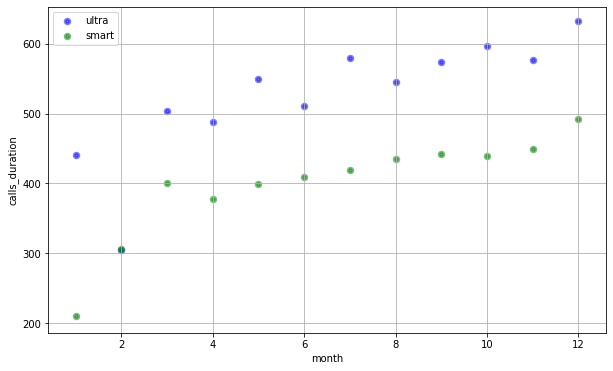

mb_sum


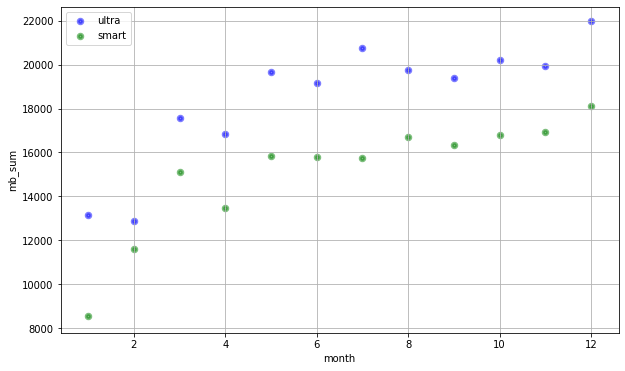

sum_messege


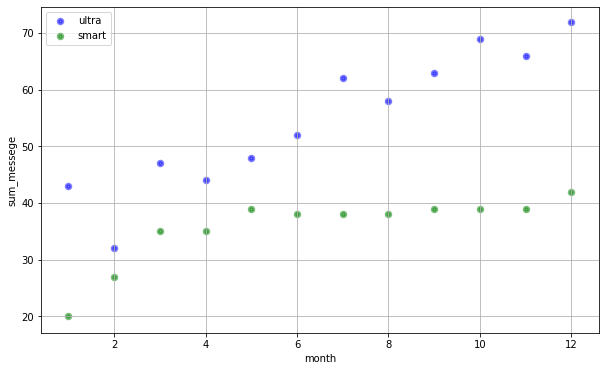

In [40]:
for col in ['calls_duration', 'mb_sum', 'sum_messege']:
    print(col)
    grafic(data_ultra, data_smart, 'month', col)

In [41]:
print('Количество пользователей тарифа smart - ', data_group_user_smart.shape[0])
print('Количество пользователей тарифа ultra - ', data_group_user_ultra.shape[0])

Количество пользователей тарифа smart -  350
Количество пользователей тарифа ultra -  148



<div style="border:solid purple 2px; padding: 20px">
<p> На графиках, построенных по таблицам сгруппированным по месяцам, видим, что значения тарифа ultra по всем показателям выше. Но прибыль выше от пользователей тарифу smart за счет большего количества пользователей. </p>
</div>


In [42]:
def count_stat(col):
    list_stat = [col.min(), col.max(), col.mean(), col.median(), col.var(), col.std()]
    stat_series = pd.Series(list_stat)
    return (stat_series)

In [43]:
def info_stat(table):
    dict_stat = {'stat_method':['min', 'max', 'mean', 'median', 'var', 'std'],
                 'calls':count_stat(table['calls_duration']), 'mb':count_stat(table['mb_sum']),
                 'messege':count_stat(table['sum_messege'])}
    if 'money' in table.columns:
        dict_stat['money'] = count_stat(table['money'])
    
    df_stat = pd.DataFrame(data=dict_stat)
    return(df_stat)

In [44]:
info_stat(data_smart)

,stat_method,calls,mb,messege
0,min,209.65,8524.86,20.00
1,max,492.88,18137.73,42.00
2,mean,398.24,15084.36,35.75
3,median,414.24,15820.74,38.00
4,var,5595.66,7175432.15,38.39
5,std,74.80,2678.70,6.20


In [45]:
info_stat(data_ultra)

,stat_method,calls,mb,messege
0,min,304.67,12858.65,32.00
1,max,631.86,21971.87,72.00
2,mean,525.07,18443.48,54.67
3,median,547.21,19533.03,55.00
4,var,7578.63,8223472.19,149.33
5,std,87.06,2867.66,12.22



<div style="border:solid purple 2px; padding: 20px">
<p> Графики по таблицам, сгруппированным по user_id </p>
</div>


calls_duration


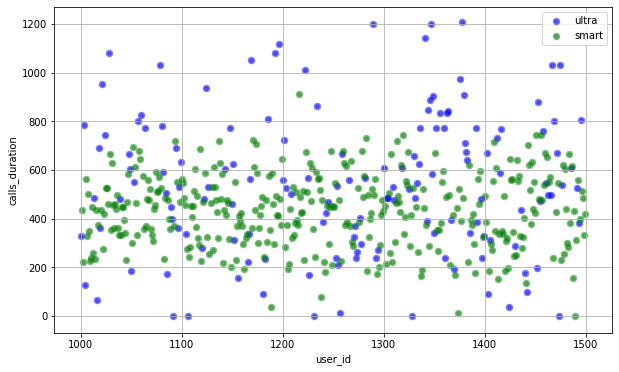

mb_sum


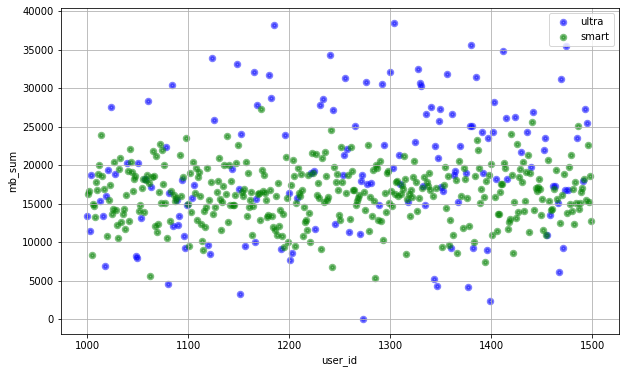

sum_messege


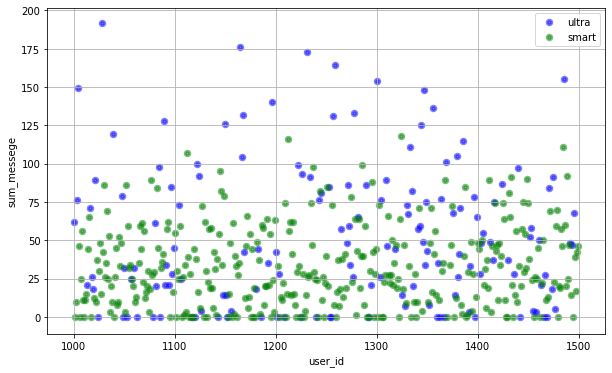

paid


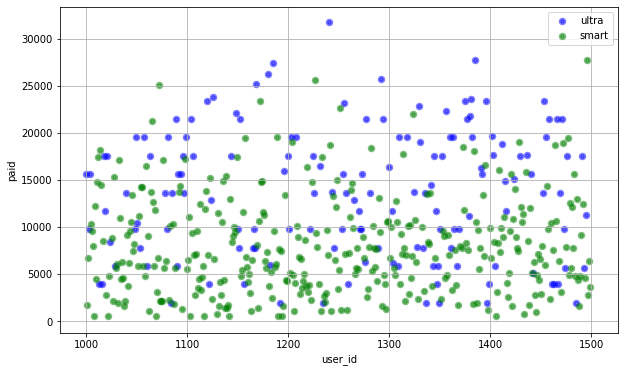

In [46]:
for col in ['calls_duration', 'mb_sum', 'sum_messege', 'paid']:
    print(col)
    grafic(data_group_user_ultra, data_group_user_smart, 'user_id', col)


<div style="border:solid purple 2px; padding: 20px">
<p> Для пользователей тарифа ultra значения по всем характеристикам, кроме суммы оплаты разбросаны шире. Значения для пользователей ultra обычно = 1950. Стандартное отклонение для пользователей smart почти вдвое ниже по исследуемым параметрам (количество звонков, траффика, сообщений). Стандартное отклонение дохода у пользователей smart в разы выше.</p>
</div>


In [47]:
money_smart = data_group_user_smart['paid'].sum()
money_ultra = data_group_user_ultra['paid'].sum()
money_all = money_smart+money_ultra

print('Прибыль от пользователей тарифа smart - {:.0f}'.format(money_smart))
print('Прибыль от пользователей тарифа ultra - {:.0f}'.format( money_ultra))
print('Прибыль от пользователей обоих тарифов - {:.0f}'.format( money_all))


Прибыль от пользователей тарифа smart - 2787217
Прибыль от пользователей тарифа ultra - 2029628
Прибыль от пользователей обоих тарифов - 4816845


In [48]:
info_stat(data_group_user_ultra)

,stat_method,calls,mb,messege
0,min,0.00,0.00,0.00
1,max,1209.91,38502.25,192.00
2,mean,542.38,19611.65,54.05
3,median,530.73,18788.09,45.50
4,var,83557.64,69064265.34,2146.35
5,std,289.06,8310.49,46.33


In [49]:
info_stat(data_group_user_smart)

,stat_method,calls,mb,messege
0,min,0.00,5391.45,0.00
1,max,913.50,27322.17,118.00
2,mean,431.15,16212.01,32.39
3,median,437.69,16290.32,27.50
4,var,22143.03,12829206.84,701.05
5,std,148.81,3581.79,26.48



<div style="border:solid purple 2px; padding: 20px">
<h3> Проверка гипотез
</h3>
</div>


<div style="border:solid purple 2px; padding: 20px">
<p> H0: средняя выручка пользователей тарифов «Ультра» и «Смарт» равны;
    </p>
<p>    H1: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
    </p>
<p> H0 всегда формулируется так, чтобы использовать знак равенства, H1 противоположна H0. У выборок сильно отличается дисперсия, значит equal_var = False. 
    </p>
</div>


In [50]:
alpha = .05
results = st.ttest_ind(data_group_user_ultra['paid'], data_group_user_smart['paid'], equal_var = False)

print('p-значение = ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение =  2.8434070349035866e-17
Отвергаем нулевую гипотезу


<div style="border:solid purple 2px; padding: 20px">
<p> H0: средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов;
    </p>
<p> H1: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
</p>
</div>


In [51]:
data_user.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [52]:
df_all.head()

,user_id,month,calls_duration,duration_count,sum_messege,mb_sum,age,churn_date,city,first_name,...,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,paid_min,paid_mb,paid_messege,paid
0,1000,5,164.00,22.00,22.00,2256.10,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.00,0.00,0.00,1950.00
1,1000,6,187.00,43.00,60.00,23257.50,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.00,0.00,0.00,1950.00
2,1000,7,346.00,47.00,75.00,14016.10,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.00,0.00,0.00,1950.00
3,1000,8,418.00,52.00,81.00,14070.20,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.00,0.00,0.00,1950.00
4,1000,9,478.00,58.00,57.00,14581.20,52,NaN,Краснодар,Рафаил,...,30720,3000,1950,150,1,1,0.00,0.00,0.00,1950.00


In [53]:
df_moscow = df_all.query('city == "Москва"')
info_stat(df_moscow)

,stat_method,calls,mb,messege
0,min,1.00,366.00,1.00
1,max,1363.00,44341.00,191.00
2,mean,482.53,17984.65,47.13
3,median,467.50,17557.60,35.00
4,var,60930.70,61654698.94,1281.84
5,std,246.84,7852.05,35.80


In [54]:
df_area = df_all.query('city != "Москва"')
info_stat(df_area)

,stat_method,calls,mb,messege
0,min,1.00,0.10,1.00
1,max,1727.00,49789.40,224.00
2,mean,466.29,17122.99,44.88
3,median,457.00,16894.45,38.00
4,var,59126.64,55297092.02,1216.50
5,std,243.16,7436.20,34.88


In [55]:
results = st.ttest_ind(df_moscow['paid'], df_area['paid'], equal_var = True)

print('p-значение = ', results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение =  0.5206875294554152
Не получилось отвергнуть нулевую гипотезу



<div style="border:solid purple 2px; padding: 20px">
<h3> Вывод
</h3>
    <p>
На графиках, построенных по таблицам сгруппированным по месяцам, видим, что значения тарифа ultra по всем показателям выше. Но прибыль выше от пользователей тарифу smart за счет большего количества пользователей.
        
   </p>
   <p>
    Cредняя выручка пользователей тарифов ultra = 1995 и smart = 1027. Думаю будет выгодно увеличивать количество пользователей тарифа ultra
    </p>
    <p>
   Средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов
    </p>
   
    
</div>

In [56]:
print('Количество пользователей тарифа smart - ', data_group_user_smart.shape[0])
print('Количество пользователей тарифа ultra - ', data_group_user_ultra.shape[0])

Количество пользователей тарифа smart -  350
Количество пользователей тарифа ultra -  148


In [57]:
print('Прибыль от пользователей тарифа smart - {:.0f}'.format(money_smart))
print('Прибыль от пользователей тарифа ultra - {:.0f}'.format( money_ultra))
print('Прибыль от пользователей обоих тарифов - {:.0f}'.format( money_all))

Прибыль от пользователей тарифа smart - 2787217
Прибыль от пользователей тарифа ultra - 2029628
Прибыль от пользователей обоих тарифов - 4816845
